<a href="https://colab.research.google.com/github/NaokiDohi/senior_thesis/blob/master/sin_lstm_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# インポート

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

# Sin波作成

In [2]:
def sin(x, T=100):
    return np.sin(2.0 * np.pi * x / T)

# sin波にノイズを付与する
def toy_problem(T=100, ampl=0.05):
    x = np.arange(0, 2 * T + 1)
    noise = ampl * np.random.uniform(low=-1.0, high=1.0, size=len(x))
    return sin(x) + noise

f = toy_problem()

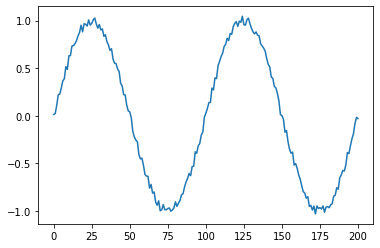

In [12]:
plt.plot(np.arange(201),f)

In [3]:
def make_dataset(low_data, n_prev=100):

    data, target = [], []
    maxlen = 25

    for i in range(len(low_data)-maxlen):
        data.append(low_data[i:i + maxlen])
        target.append(low_data[i + maxlen])

    re_data = np.array(data).reshape(len(data), maxlen, 1)
    re_target = np.array(target).reshape(len(data), 1)

    return re_data, re_target


#g -> 学習データ，h -> 学習ラベル
g, h = make_dataset(f)

In [27]:
g.shape

(176, 25, 1)

In [28]:
h.shape

(176, 1)

In [29]:
length_of_sequence = g.shape[1] 
in_out_neurons = 1
n_hidden = 300

model = Sequential()
model.add(LSTM(n_hidden, batch_input_shape=(None, length_of_sequence, in_out_neurons), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(n_hidden, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(n_hidden, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(in_out_neurons))
model.add(Activation("linear"))
optimizer = Adam(lr=0.001)
model.compile(loss="mean_squared_error", optimizer=optimizer,metrics=["acc"])# optimizer="rmsprop"
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 25, 300)           362400    
_________________________________________________________________
dropout_6 (Dropout)          (None, 25, 300)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 25, 300)           721200    
_________________________________________________________________
dropout_7 (Dropout)          (None, 25, 300)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dropout_8 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [30]:
#early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)
epochs=100#200
history = model.fit(g, h, batch_size=300, epochs=epochs, validation_split=0.1, verbose=0)

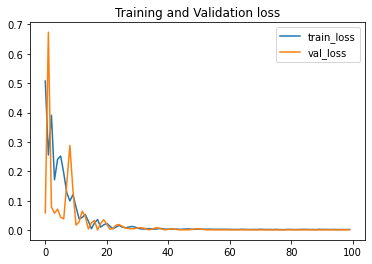

In [14]:
# === 学習推移の可視化 ===
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(np.arange(len(train_loss)), train_loss, label="train_loss")
plt.plot(np.arange(len(val_loss)), val_loss, label="val_loss")
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [19]:
predicted_train_data = model.predict(g)

No handles with labels found to put in legend.


[]

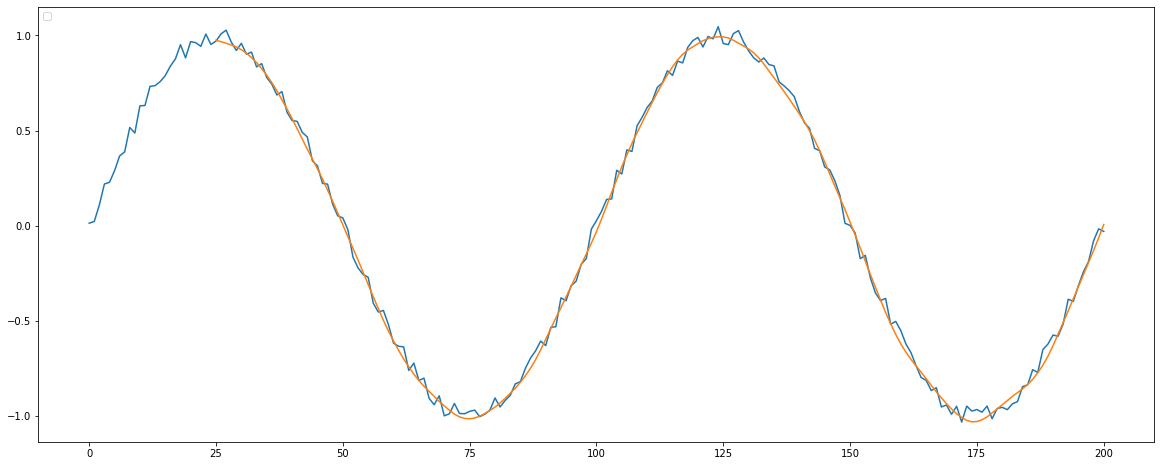

In [20]:
plt.figure(figsize=(20,8))
plt.legend(loc='upper left')
plt.plot(np.arange(201),f,label='original')
plt.plot(np.arange(176)+25,predicted_train_data,label='past_predict')
plt.plot()

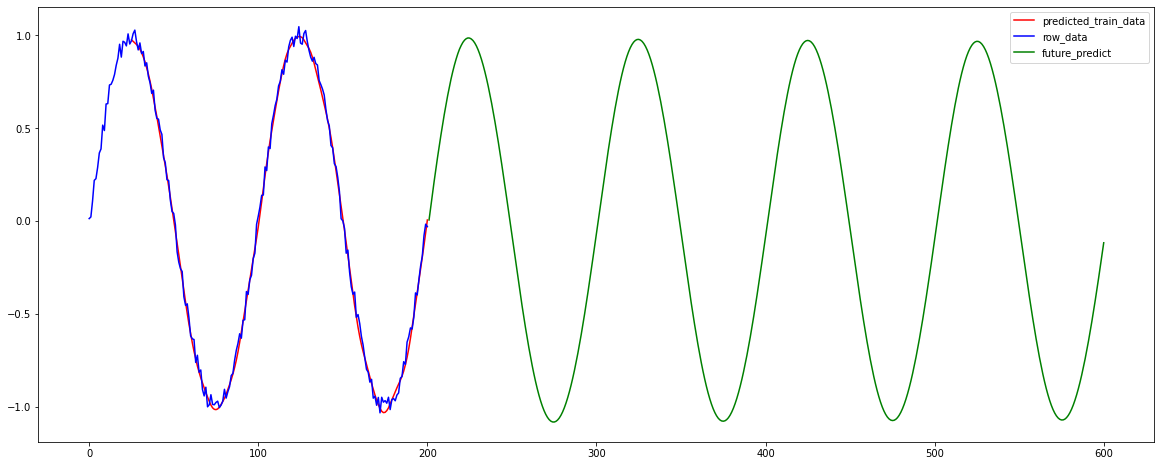

In [26]:
future_test = g[-1].T
# 1つの学習データの時間の長さ -> 25
time_length = future_test.shape[1]
# 未来の予測データを保存していく変数
future_result = np.empty((0))

# 未来予想
for step2 in range(400):

    test_data = np.reshape(future_test, (1, time_length, 1))
    batch_predict = model.predict(test_data)

    future_test = np.delete(future_test, 0)
    future_test = np.append(future_test, batch_predict)

    future_result = np.append(future_result, batch_predict)


# sin波をプロット
plt.figure(figsize=(20,8))
plt.plot(range(25,len(predicted_train_data)+25),predicted_train_data, color="r", label="predicted_train_data")
plt.plot(range(0, len(f)), f, color="b", label="row_data")
plt.plot(range(0+len(f), len(future_result)+len(f)), future_result, color="g", label="future_predict")
plt.legend()
plt.show()